<a href="https://colab.research.google.com/github/Vedh-vamsi/Brain-Guardian-Brain-Tumor-Detection-/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install colorama

In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


In [ ]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   ├── MyDrive
│   │   ├── 209X1A05B7
│   │   │   ├── Geometric constructions
│   │   │   ├── Projections of lines
│   │   │   ├── Projections of planes
│   │   │   └── Projections of points
│   │   ├── 209X1A05C1
│   │   │   └── Unit-1
│   │   ├── Brain_Tumor_Detection
│   │   │   ├── no
│   │   │   ├── pred
│   │   │   └── yes
│   │   ├── Classroom
│   │   │   ├── 2021-2022 IV SEM CSE B
│   │   │   ├── 3BSTLD21-22 3B
│   │   │   ├── 4AOS2021_22 A
│   │   │   ├── ADS-III-CSE-B B
│   │   │   ├── ADS LAB EXAM B
│   │   │   ├── cse 5th semister section B
│   │   │   ├── CSE B
│   │   │   ├── CSE- B
│   │   │   ├── CSE B VII
│   │   │   ├── CSE III SEM DBS 2021-22 B-Section
│   │   │   ├── DL-B 2023-24 DL-B-2023-24
│   │   │   ├── ED_CSE-B_2020-2021
│   │   │   ├── EEE CSE B B SECTION
│   │   │   ├── ENGLISH- YVSK II SEMESTER CSE-B
│   │   │   ├── EPC-CSE(B)&CST-AS CSE B & CST
│   │   │   ├── EPC  I BTech      CSE   B    20-21 BML  & GA
│   │   │   ├── HABIB_IT INTERNSHIP
│  

In [ ]:
IMG_PATH = "/content/drive/MyDrive/Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [ ]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
<ipython-input-7-59831cb31691>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



1804 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

601 images loaded from VAL/ directory.


In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

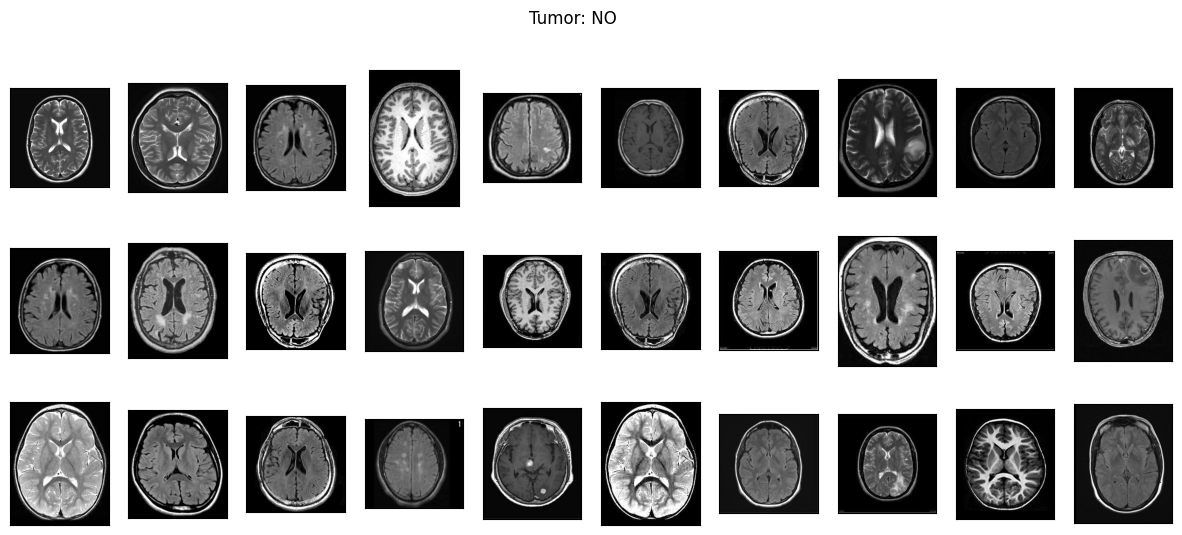

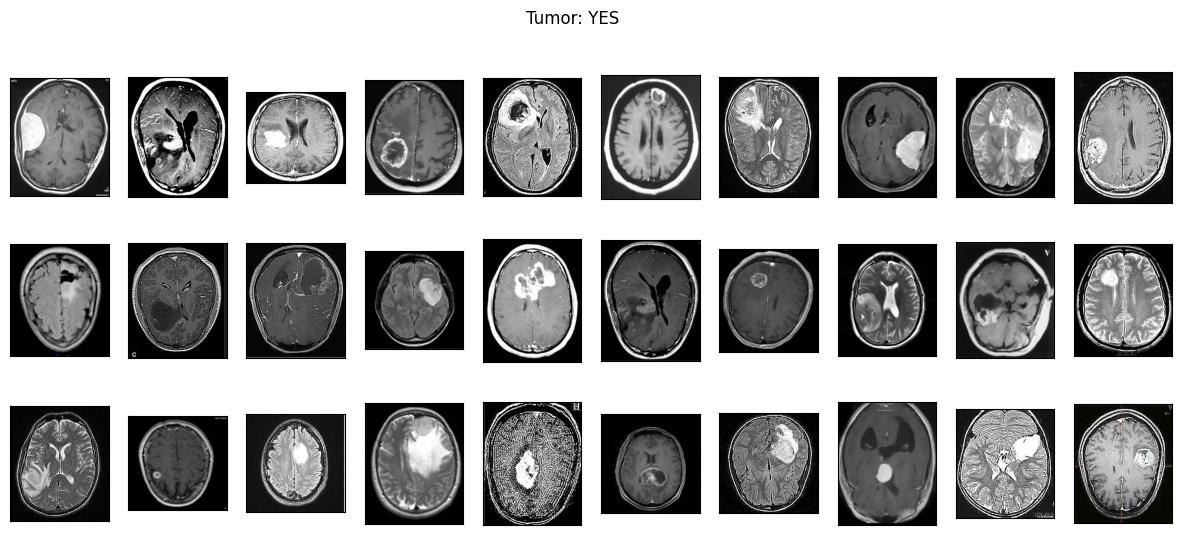

In [ ]:
plot_samples(X_train, y_train, labels, 30)

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
import imutils
img = cv2.imread('/content/VAL/NO/no1170.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

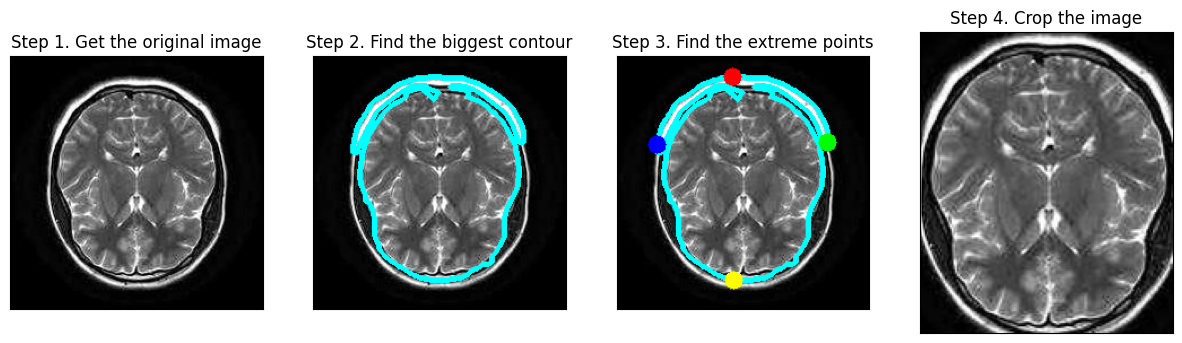

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<ipython-input-12-65876982ba26>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



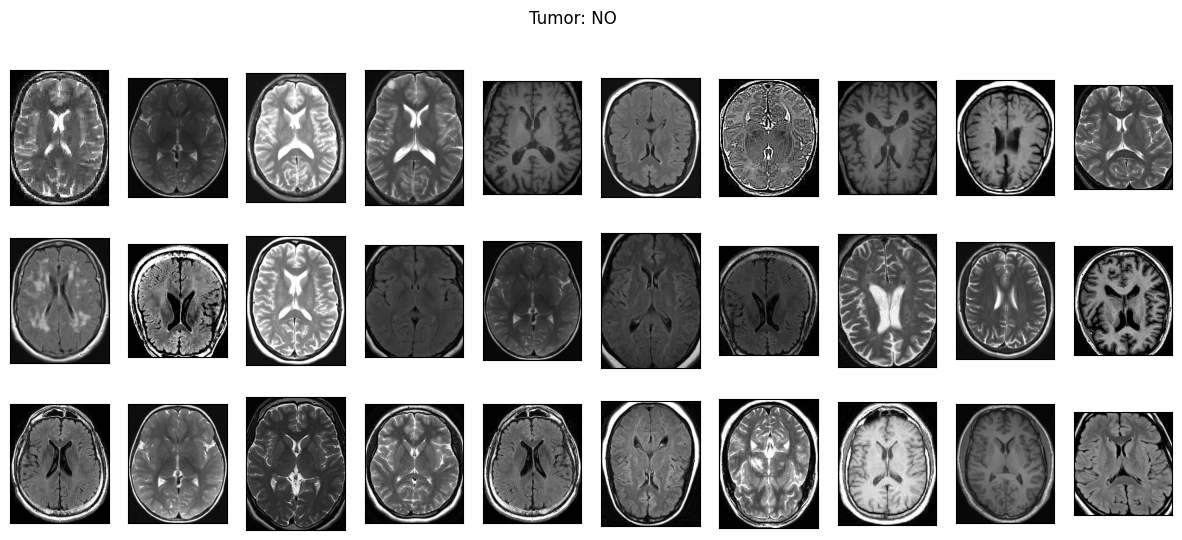

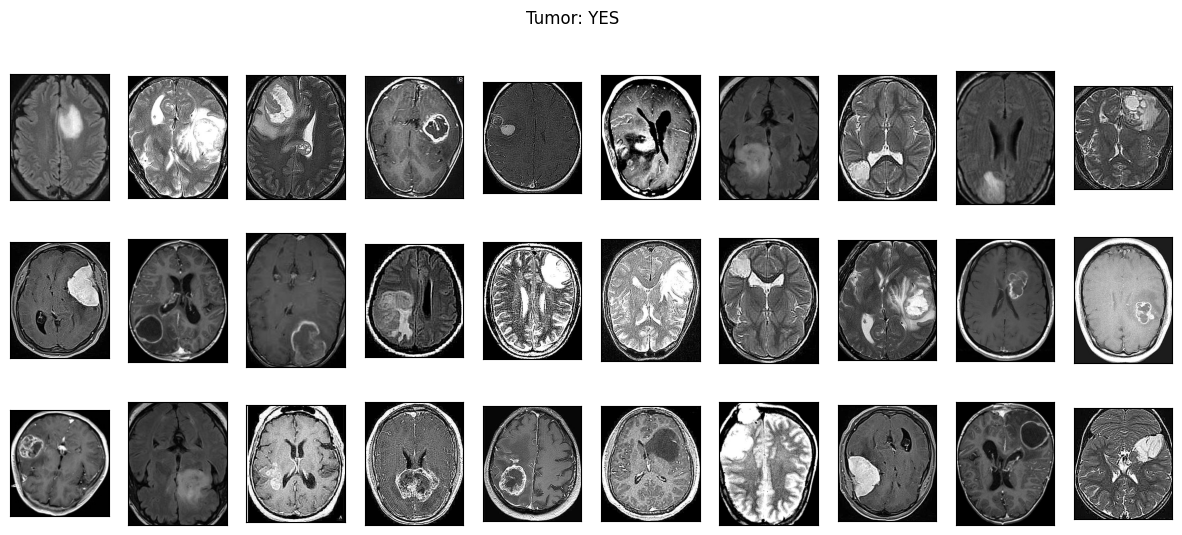

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

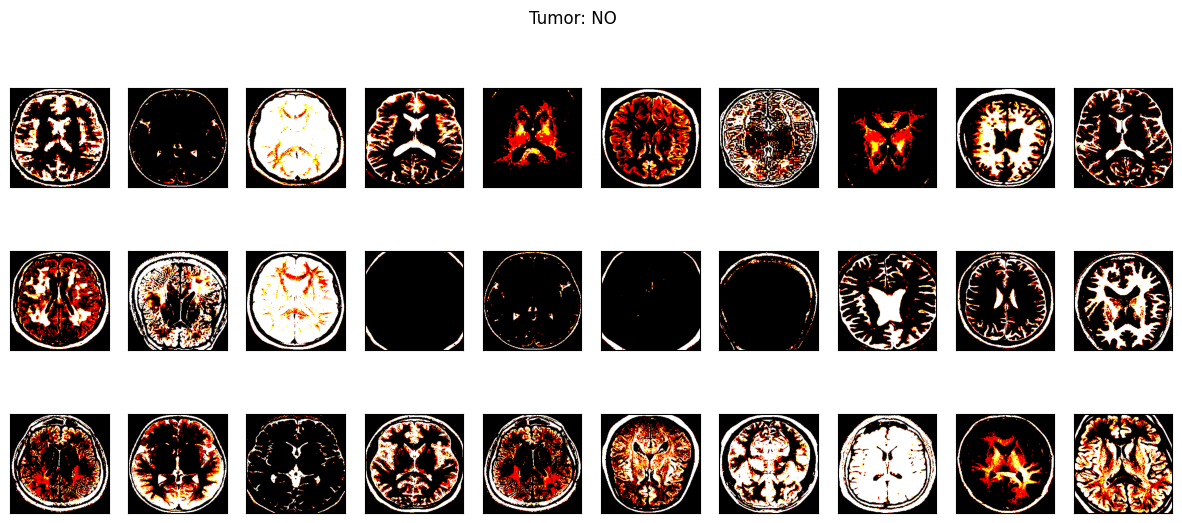

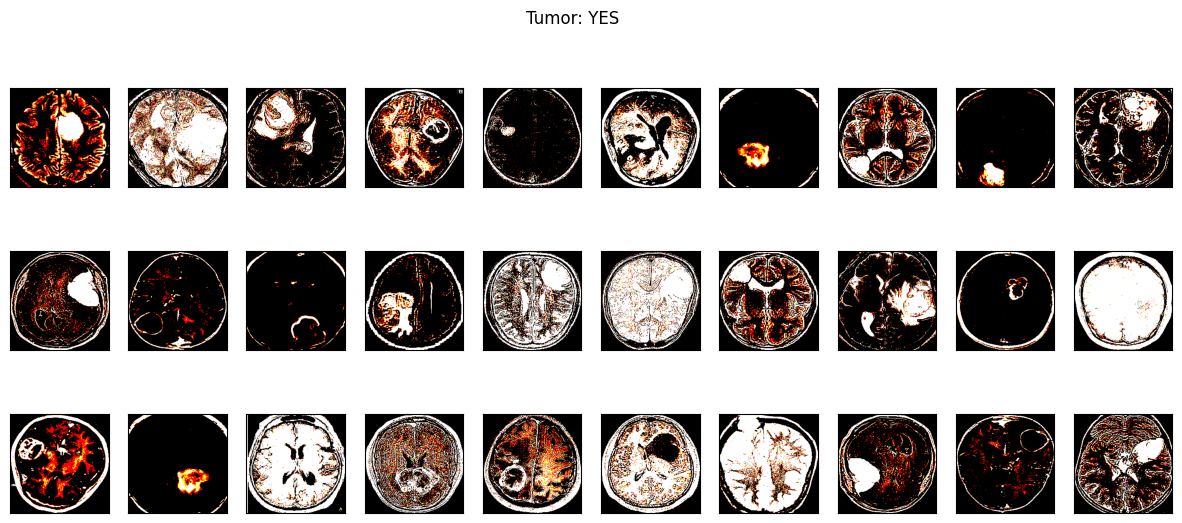

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

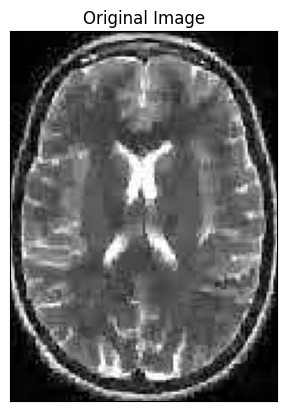

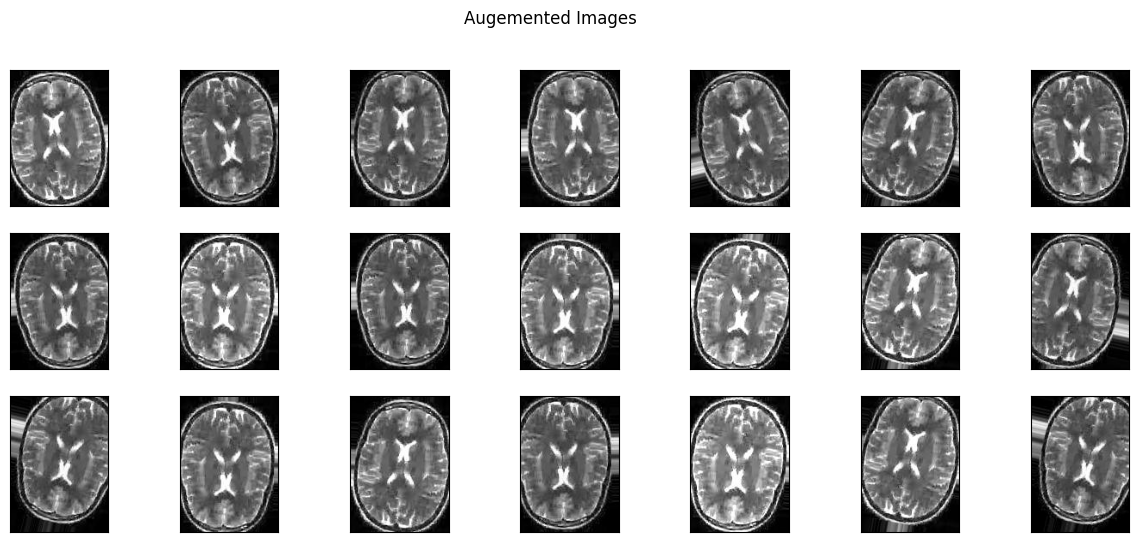

In [ ]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview1')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview1', save_prefix='aug_img1', save_format='jpg'):
    i += 1
    if i > 20:
        break

plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview1/'):
    img = cv2.imread('preview1/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()


In [ ]:
!rm -rf preview1/

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1804 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


In [ ]:
base_Neural_Net= ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                       

In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

<ipython-input-28-f8b1bbfef07d>:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8576 - auc: 0.9243

50/50 [==============================] - 60s 749ms/step - loss: 0.3717 - accuracy: 0.8576 - auc: 0.9243 - val_loss: 0.2209 - val_accuracy: 0.9350 - val_auc: 0.9764
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9294 - auc: 0.9779

50/50 [==============================] - 36s 724ms/step - loss: 0.1900 - accuracy: 0.9294 - auc: 0.9779 - val_loss: 0.0941 - val_accuracy: 0.9725 - val_auc: 0.9955
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9532 - auc: 0.9892

50/50 [==============================] - 31s 624ms/step - loss: 0.1335 - accuracy: 0.9532 - auc: 0.9892 - val_loss: 0.0935 - val_accuracy: 0.9675 - val_auc: 0.9975
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9538 - auc: 0.9926

50/50 [==============================] - 32s 631ms/step - loss: 0.1124 - accuracy: 0.9538 - auc: 0.9926 - val_loss: 0.0930 - val_accuracy: 0.9625 - val_auc: 0.9964
Epoch 5/30
50/50 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9681 - auc: 0.9930

50/50 [==============================] - 34s 675ms/step - loss: 0.1054 - accuracy: 0.9681 - auc: 0.9930 - val_loss: 0.0698 - val_accuracy: 0.9725 - val_auc: 0.9991
Epoch 6/30
50/50 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9665 - auc: 0.9935

50/50 [==============================] - 31s 615ms/step - loss: 0.0987 - accuracy: 0.9665 - auc: 0.9935 - val_loss: 0.0858 - val_accuracy: 0.9675 - val_auc: 0.9980
Epoch 7/30
50/50 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9829 - auc: 0.9976

50/50 [==============================] - 32s 632ms/step - loss: 0.0647 - accuracy: 0.9829 - auc: 0.9976 - val_loss: 0.0807 - val_accuracy: 0.9650 - val_auc: 0.9986
Epoch 8/30
50/50 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9747 - auc: 0.9967

50/50 [==============================] - 31s 623ms/step - loss: 0.0748 - accuracy: 0.9747 - auc: 0.9967 - val_loss: 0.0711 - val_accuracy: 0.9675 - val_auc: 0.9996
Epoch 9/30
50/50 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9633 - auc: 0.9942

50/50 [==============================] - 33s 654ms/step - loss: 0.0998 - accuracy: 0.9633 - auc: 0.9942 - val_loss: 0.0910 - val_accuracy: 0.9675 - val_auc: 0.9980
Epoch 10/30
50/50 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9753 - auc: 0.9950

50/50 [==============================] - 31s 625ms/step - loss: 0.0767 - accuracy: 0.9753 - auc: 0.9950 - val_loss: 0.0833 - val_accuracy: 0.9650 - val_auc: 0.9993
Epoch 11/30
50/50 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9759 - auc: 0.9970

50/50 [==============================] - 34s 682ms/step - loss: 0.0680 - accuracy: 0.9759 - auc: 0.9970 - val_loss: 0.0811 - val_accuracy: 0.9725 - val_auc: 0.9989
Epoch 12/30
50/50 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9741 - auc: 0.9972

50/50 [==============================] - 31s 617ms/step - loss: 0.0689 - accuracy: 0.9741 - auc: 0.9972 - val_loss: 0.0430 - val_accuracy: 0.9825 - val_auc: 0.9999
Epoch 13/30
50/50 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9831 - auc: 0.9989

50/50 [==============================] - 30s 601ms/step - loss: 0.0482 - accuracy: 0.9831 - auc: 0.9989 - val_loss: 0.0725 - val_accuracy: 0.9750 - val_auc: 0.9985
Epoch 14/30
50/50 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9831 - auc: 0.9990

50/50 [==============================] - 33s 649ms/step - loss: 0.0463 - accuracy: 0.9831 - auc: 0.9990 - val_loss: 0.0630 - val_accuracy: 0.9775 - val_auc: 0.9992
Epoch 15/30
50/50 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9861 - auc: 0.9986

50/50 [==============================] - 32s 630ms/step - loss: 0.0480 - accuracy: 0.9861 - auc: 0.9986 - val_loss: 0.0702 - val_accuracy: 0.9775 - val_auc: 0.9965
Epoch 16/30
50/50 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9869 - auc: 0.9984

50/50 [==============================] - 31s 630ms/step - loss: 0.0431 - accuracy: 0.9869 - auc: 0.9984 - val_loss: 0.0630 - val_accuracy: 0.9825 - val_auc: 0.9963
Epoch 17/30
50/50 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9791 - auc: 0.9981

50/50 [==============================] - 29s 580ms/step - loss: 0.0559 - accuracy: 0.9791 - auc: 0.9981 - val_loss: 0.0834 - val_accuracy: 0.9750 - val_auc: 0.9937
Epoch 18/30
50/50 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9816 - auc: 0.9987

50/50 [==============================] - 32s 636ms/step - loss: 0.0474 - accuracy: 0.9816 - auc: 0.9987 - val_loss: 0.0937 - val_accuracy: 0.9725 - val_auc: 0.9930
Epoch 19/30
50/50 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9869 - auc: 0.9995

50/50 [==============================] - 33s 664ms/step - loss: 0.0338 - accuracy: 0.9869 - auc: 0.9995 - val_loss: 0.1167 - val_accuracy: 0.9650 - val_auc: 0.9937
Epoch 20/30
50/50 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9804 - auc: 0.9985

50/50 [==============================] - 32s 649ms/step - loss: 0.0495 - accuracy: 0.9804 - auc: 0.9985 - val_loss: 0.0534 - val_accuracy: 0.9825 - val_auc: 0.9994
Epoch 21/30
50/50 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9905 - auc: 0.9998

50/50 [==============================] - 33s 651ms/step - loss: 0.0263 - accuracy: 0.9905 - auc: 0.9998 - val_loss: 0.0625 - val_accuracy: 0.9800 - val_auc: 0.9964
Epoch 22/30
50/50 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9867 - auc: 0.9995

50/50 [==============================] - 29s 579ms/step - loss: 0.0335 - accuracy: 0.9867 - auc: 0.9995 - val_loss: 0.0755 - val_accuracy: 0.9775 - val_auc: 0.9963
Epoch 23/30
50/50 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9867 - auc: 0.9992

50/50 [==============================] - 32s 631ms/step - loss: 0.0370 - accuracy: 0.9867 - auc: 0.9992 - val_loss: 0.0442 - val_accuracy: 0.9875 - val_auc: 0.9996
Epoch 24/30
50/50 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9930 - auc: 0.9996

50/50 [==============================] - 34s 679ms/step - loss: 0.0266 - accuracy: 0.9930 - auc: 0.9996 - val_loss: 0.0536 - val_accuracy: 0.9875 - val_auc: 0.9991
Epoch 25/30
50/50 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9943 - auc: 0.9996

50/50 [==============================] - 31s 629ms/step - loss: 0.0223 - accuracy: 0.9943 - auc: 0.9996 - val_loss: 0.0632 - val_accuracy: 0.9825 - val_auc: 0.9966
Epoch 26/30
50/50 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9905 - auc: 0.9996

50/50 [==============================] - 31s 623ms/step - loss: 0.0281 - accuracy: 0.9905 - auc: 0.9996 - val_loss: 0.0408 - val_accuracy: 0.9875 - val_auc: 0.9991
Epoch 27/30
50/50 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9925 - auc: 0.9986

50/50 [==============================] - 31s 629ms/step - loss: 0.0330 - accuracy: 0.9925 - auc: 0.9986 - val_loss: 0.0397 - val_accuracy: 0.9900 - val_auc: 0.9990
Epoch 28/30
50/50 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9867 - auc: 0.9994

50/50 [==============================] - 32s 649ms/step - loss: 0.0328 - accuracy: 0.9867 - auc: 0.9994 - val_loss: 0.0753 - val_accuracy: 0.9775 - val_auc: 0.9967
Epoch 29/30
50/50 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9892 - auc: 0.9995

50/50 [==============================] - 30s 603ms/step - loss: 0.0305 - accuracy: 0.9892 - auc: 0.9995 - val_loss: 0.1012 - val_accuracy: 0.9750 - val_auc: 0.9940
Epoch 30/30
50/50 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9842 - auc: 0.9987

50/50 [==============================] - 34s 684ms/step - loss: 0.0454 - accuracy: 0.9842 - auc: 0.9987 - val_loss: 0.0676 - val_accuracy: 0.9775 - val_auc: 0.9995


In [ ]:
import pickle

In [ ]:
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

In [ ]:
with open('/content/drive/MyDrive/model_pk.pkl' , 'rb') as f:
    lr = pickle.load(f)

57/57 [==============================] - 15s 100ms/step
Train Accuracy = 1.00


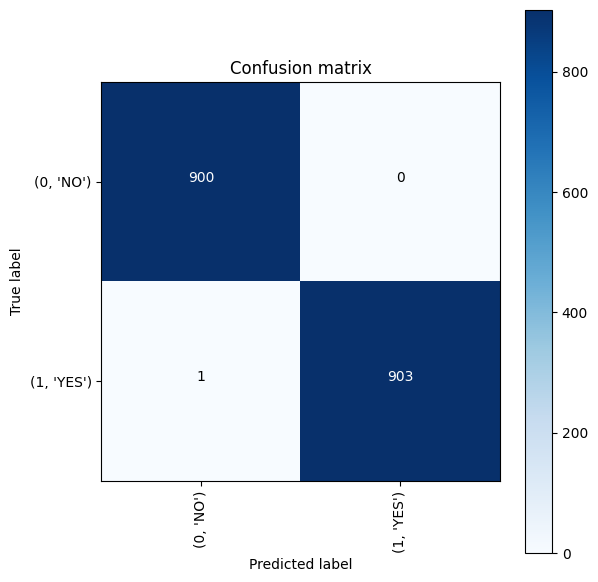

In [ ]:
predictions = lr.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 2s 110ms/step
Val Accuracy = 0.98


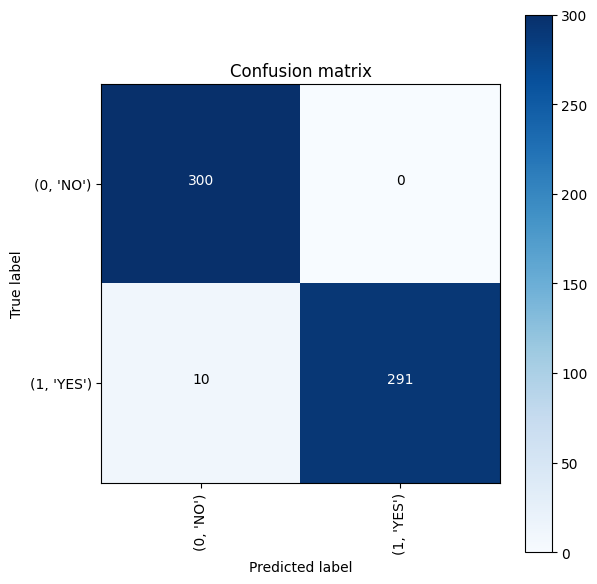

In [ ]:
predictions = lr.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 2s 107ms/step
Test Accuracy = 0.95


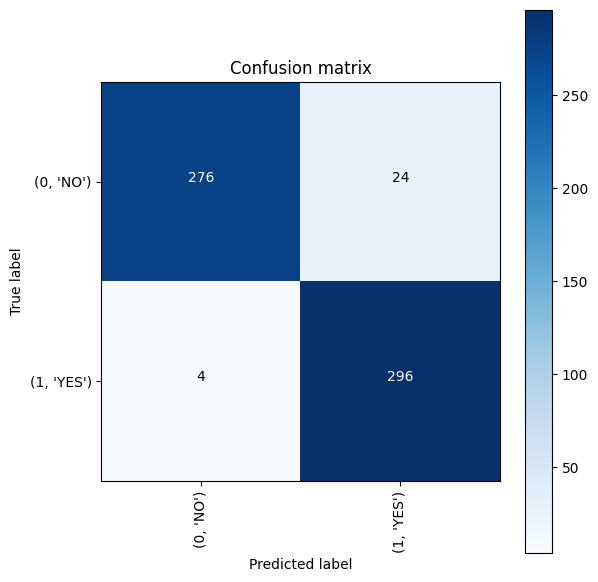

In [ ]:
predictions = lr.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
prob_pred = model.predict(X_test_prep)

19/19 [==============================] - 3s 156ms/step


In [ ]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9533
Precision score is : 0.9554
Recall score is : 0.9533
F1 Score is : 0.9533
ROC AUC Score is : 0.3792
Cohen Kappa Score: 0.9067
		Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       300
           1       0.93      0.99      0.95       300

    accuracy                           0.95       600
   macro avg       0.96      0.95      0.95       600
weighted avg       0.96      0.95      0.95       600

